### Prerequisites

In [31]:
# Import necessary packages
import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
import pygmsh as pgm
import matplotlib
import matplotlib.pyplot as plt

# Select the running mode: True-training, False-prediction
runMode = True

# Choose the material
material = 'PdCdCl4'

# Settle the calculation of my model onto GPU
torch.cuda.init()
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is being used")

CUDA is being used


### Parameters in the governing equations and normalization

In [32]:
a = 10e-9   # radius
q = 307.4e6 # transverse loading
'''
Examples of material constants [SI units]
-----------------------------------------
Hexagonal: Graphene
Original values from literatures:
E_2D = 345.0, nu = 0.16
D = 2.38e-19, D_G = 2.43e-19
Input parameters:
# In-plane stiffness matrix
C11_2D = 354.1
C22_2D = 354.1
C12_2D = 56.7
C16_2D = 0
C26_2D = 0
C66_2D = 148.7
# Out-of-plane stiffness matrix
D11 = 2.38e-19
D22 = 2.38e-19
D12 = -0.05e-19
D16 = 0
D26 = 0
D66 = 1.215e-19
-----------------------------------------
Rectangular: Phosphorene
Original values from literatures:
h = 0.555e-9, E1 = 166e9, E2 = 44e9
G12 = 41e9, nu12 = 0.17, nu21 = 0.62
D11 = 1.421e-18; D22 = 0.307e-18
D12 = 0.336e-18; D66 = 0.175e-18
Input parameters:
# In-plane stiffness matrix
C11_2D = 102.98
C22_2D = 27.30
C12_2D = 17.51
C16_2D = 0
C26_2D = 0
C66_2D = 22.76
# Out-of-plane stiffness matrix
D11 = 1.421e-18
D22 = 0.307e-18
D12 = 0.336e-18
D16 = 0
D26 = 0
D66 = 0.175e-18
-----------------------------------------
Square: Mn2S2
# Values from database:
C11_2D = 121.83
C22_2D = 121.83
C12_2D = 33.90
C16_2D = 0
C26_2D = 0
C66_2D = 108.45
# Bending stiffness(testing):
D11 = 1.0e-18
D22 = 1.0e-18
D12 = 0.25e-18
D16 = 0.0
D26 = 0.0
D66 = 1.0e-18
-----------------------------------------
Oblique: PdCdCl4
# Values from database:
C11_2D = 12.38
C22_2D = 37.00
C12_2D = 8.50
C16_2D = 3.24
C26_2D = 9.76
C66_2D = 14.48
# Bending stiffness(testing):
D11 = 1.0e-18
D22 = 3.0e-18
D12 = 0.6e-18
D16 = 0.25e-18
D26 = 0.75e-18
D66 = 1.0e-18
'''
# Effective thickness
he = 0.1e-9

# Values from database:
C11_2D = 12.38
C22_2D = 37.00
C12_2D = 8.50
C16_2D = 3.24
C26_2D = 9.76
C66_2D = 14.48
# Bending stiffness(testing):
D11 = 1.0e-18
D22 = 3.0e-18
D12 = 0.6e-18
D16 = 0.25e-18
D26 = 0.75e-18
D66 = 1.0e-18

# Normalization
Q = 2*q*he**3/(D11 + D22)
A = a/he

# Scale up bending stiffness
B11 = D11/he**2
B22 = D22/he**2
B12 = D12/he**2
B16 = D16/he**2
B26 = D26/he**2
B66 = D66/he**2

### Define the neural network

In [33]:
class Net(nn.Module):
    # Define a new class inheriting nn.Module
    def __init__(self, nInput, nOutput, hiddenSizes):
        # Initialize basic information for the network
        super(Net, self).__init__()

        # Define the input layer: reflection + weight + bias
        self.Input = nn.Linear(nInput, hiddenSizes[0])
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        # Define the output layer: reflection + weight + bias
        self.Output = nn.Linear(hiddenSizes[-1], nOutput)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        # Define the hidden layers: reflection + weight + bias
        self.Hidden = nn.ModuleList()
        for i in range(len(hiddenSizes) - 1):
            layer = nn.Linear(hiddenSizes[i], hiddenSizes[i+1])
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
            self.Hidden.append(layer)

    # Define the activation function
    def forward(self, inputData):
        tensor = torch.tanh(self.Input(inputData))
        for layer in self.Hidden:
            tensor = torch.tanh(layer(tensor))
        outputData = self.Output(tensor)
        return outputData

### Define the derivatives

In [34]:
def Derivatives(inputData, Net, func_HBC):
    outputData = Net(inputData)*(func_HBC(inputData).view(-1, 1))
    # Evaluate first derivatives
    jacobian = torch.autograd.grad(outputData,
                                   inputData,
                                   torch.ones_like(outputData),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    partial_X = jacobian[0][:, 0].view(-1, 1)
    partial_Y = jacobian[0][:, 1].view(-1, 1)

    # Evaluate second derivatives
    hessianX = torch.autograd.grad(partial_X,
                                   inputData,
                                   torch.ones_like(partial_X),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    hessianY = torch.autograd.grad(partial_Y,
                                   inputData,
                                   torch.ones_like(partial_Y),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    partial_XX = hessianX[0][:, 0].view(-1, 1)
    partial_YY = hessianY[0][:, 1].view(-1, 1)
    partial_XY = 0.5*(hessianX[0][:, 1].view(-1, 1) + hessianY[0][:, 0].view(-1, 1))

    return partial_X, partial_Y, partial_XX, partial_YY, partial_XY

### Evaluate the free energy

In [35]:
def freeEnergy(inputData, NetU, NetV, NetW, funcUV, funcW):
    # Deflection
    W = NetW(inputData)*(funcW(inputData).view(-1, 1))

    # Evaluate derivatives
    U_X, U_Y, _, _, _ = Derivatives(inputData, NetU, funcUV)
    V_X, V_Y, _, _, _ = Derivatives(inputData, NetV, funcUV)
    W_X, W_Y, W_XX, W_YY, W_XY = Derivatives(inputData, NetW, funcW)

    # Evaluate strains and curvatures
    EX = U_X + 0.5*W_X**2
    EY = V_Y + 0.5*W_Y**2
    GXY = U_Y + V_X + W_X*W_Y
    KX, KY, KXY = -W_XX, -W_YY, -W_XY

    # Constitutive equations
    NX = C11_2D*EX + C12_2D*EY + C16_2D*GXY
    NY = C12_2D*EX + C22_2D*EY + C26_2D*GXY
    NXY = C16_2D*EX + C26_2D*EY + C66_2D*GXY

    MX = B11*KX + B12*KY + B16*KXY
    MY = B12*KX + B22*KY + B26*KXY
    MXY = B16*KX + B26*KY + B66*2*KXY

    # Evaluate potential energy density
    U_m = 0.5*(NX*EX + NY*EY + NXY*GXY)
    '''
    U_m_nl = (1/6*(C111_2D*EX**3 + C222_2D*EY**3) + C112_2D*EX**2*EY +
              (C111_2D - C222_2D + C112_2D)*EX*EY**2 + (3/4*C222_2D - 1/2*C111_2D - 1/4*C112_2D)*EX*GXY**2 +
              (1/2*C111_2D - 1/4*C222_2D - 1/4*C112_2D)*EY*GXY**2)
    U_m = U_m + U_m_nl
    '''
    U_b = 0.5*(MX*KX + MY*KY + MXY*(2*KXY))


    # Evaluate the total energy over the domain
    Phi_m, Phi_b = torch.mean(U_m), torch.mean(U_b)

    V = torch.mean(-0.5*Q*(B11 + B22)*W)
    return Phi_m, Phi_b, V

### Define the training data

In [36]:
def trainingData(nSample):
    coordinates = 2*A*torch.rand(nSample, 2) - A
    return coordinates.requires_grad_(True)

 ### Preparation before training

In [37]:
# Set up training data
nSample = 100000

inputData = trainingData(nSample)

# Construct neural networks for each output
hiddenSizesW = [32, 64, 64, 64, 32]
hiddenSizesUV = [32, 64, 64, 64, 32]

NetU = Net(2, 1, hiddenSizesUV)
NetV = Net(2, 1, hiddenSizesUV)
NetW = Net(2, 1, hiddenSizesW)

# Impose hard boundary conditions
def funcUV(inputData):
    return (1 - inputData[:, 0]**2/A**2)*(1 - inputData[:, 1]**2/A**2)

def funcW(inputData):
    return funcUV(inputData)**2

### Training

Epoch:100, Total:-1.1394e-01, Membrane:1.5515e-03, Bending:2.5982e-03External:-1.1809e-01 
Epoch:200, Total:-1.6260e-01, Membrane:5.3843e-03, Bending:5.6264e-03External:-1.7361e-01 
Epoch:300, Total:-2.0080e-01, Membrane:1.4870e-02, Bending:9.3654e-03External:-2.2504e-01 
Epoch:400, Total:-2.2424e-01, Membrane:2.9530e-02, Bending:1.3199e-02External:-2.6697e-01 
Epoch:500, Total:-2.3481e-01, Membrane:4.5122e-02, Bending:1.6347e-02External:-2.9628e-01 
Epoch:600, Total:-2.4053e-01, Membrane:5.8312e-02, Bending:1.8590e-02External:-3.1743e-01 
Epoch:700, Total:-2.3994e-01, Membrane:6.6305e-02, Bending:1.9949e-02External:-3.2620e-01 
Epoch:800, Total:-2.3931e-01, Membrane:7.0060e-02, Bending:2.0470e-02External:-3.2984e-01 
Epoch:900, Total:-2.3942e-01, Membrane:7.1901e-02, Bending:2.0805e-02External:-3.3213e-01 
Epoch:1000, Total:-2.3955e-01, Membrane:7.2524e-02, Bending:2.0749e-02External:-3.3283e-01 
Epoch:1100, Total:-2.3932e-01, Membrane:7.2584e-02, Bending:2.0771e-02External:-3.3268e-0

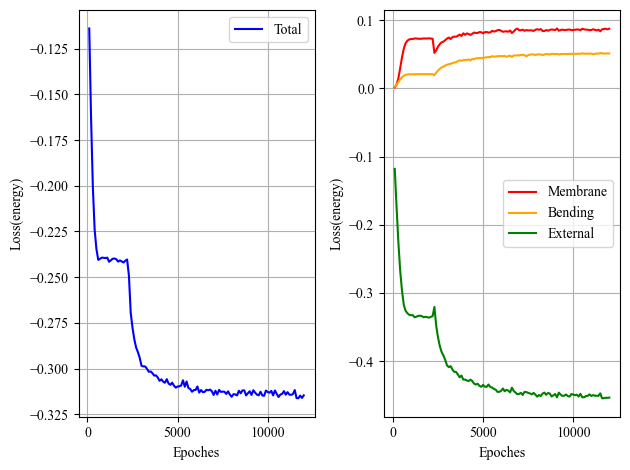

In [38]:
# Set up parameters for outer training
nEpochesAdam = 12000
intervalAdam = 100
learningRate = 2e-3

# Set up details for optimizers
optimizerAdam = Adam(
    list(NetU.parameters()) + list(NetV.parameters()) + list(NetW.parameters()) ,
    lr=learningRate,
    weight_decay=0)

scheduler = ReduceLROnPlateau(
    optimizerAdam,
    mode='min',
    factor=0.5,
    patience=1500,
    threshold=1e-4,
    min_lr=1e-5
)

# Set up recorders for monitoring
lossHistory_adam = []
energy = {'membrane': None,'bending': None, "external": None}

if runMode == True:
    # First stage: Adam
    #print('First stage: Adam')
    for epoch in range(nEpochesAdam):
        # Evaluate the loss then implement backpropagation
        Phi_m, Phi_b, V = freeEnergy(inputData, NetU, NetV, NetW, funcUV, funcW)
        loss = Phi_m + Phi_b + V
        loss.backward()
        optimizerAdam.step()
        optimizerAdam.zero_grad()
        scheduler.step(loss.item())

        # Monitor
        if (epoch + 1) % intervalAdam == 0:
            # Re-sampling
            inputData = trainingData(nSample)

            # Record the loss history
            loss_Phi_m = Phi_m.detach().cpu().item()
            loss_Phi_b = Phi_b.detach().cpu().item()
            loss_V = V.detach().cpu().item()
            totalLoss = loss_Phi_m + loss_Phi_b + loss_V
            lossHistory_adam.append([totalLoss, loss_Phi_m, loss_Phi_b, loss_V])
            print(f'Epoch:{epoch+1}, '
                  f'Total:{totalLoss:.4e}, '
                  f'Membrane:{loss_Phi_m:.4e}, '
                  f'Bending:{loss_Phi_b:.4e}'
                  f'External:{loss_V:.4e} ')

    # Show the loss history
    timeAdam = [(i + 1)*intervalAdam for i in range(len(lossHistory_adam))]
    lossHistory_adam = np.array(lossHistory_adam)

    loss_data = np.column_stack((timeAdam, lossHistory_adam))
    np.savetxt(f'{material}-plate-loss.dat', loss_data, fmt='%.8f')

    fig = plt.figure()

    # Total loss
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(timeAdam, lossHistory_adam[:, 0], label='Total', color='blue')
    ax1.set_xlabel('Epoches')
    ax1.set_ylabel('Loss(energy)')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Energy in time
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(timeAdam, lossHistory_adam[:, 1], label='Membrane', color='red')
    ax2.plot(timeAdam, lossHistory_adam[:, 2], label='Bending', color='orange')
    ax2.plot(timeAdam, lossHistory_adam[:, 3], label='External', color='green')
    ax2.set_xlabel('Epoches')
    ax2.set_ylabel('Loss(energy)')
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


    # Save the model
    torch.save(NetU.state_dict(), f'{material}-plate-NetU.pth')
    torch.save(NetV.state_dict(), f'{material}-plate-NetV.pth')
    torch.save(NetW.state_dict(), f'{material}-plate-NetW.pth')


### Prediction

In [39]:
if runMode == False:
    # Load the model's parameters
    NetU.load_state_dict(torch.load(f'{material}-plate-NetU.pth', weights_only=True))
    NetV.load_state_dict(torch.load(f'{material}-plate-NetV.pth', weights_only=True))
    NetW.load_state_dict(torch.load(f'{material}-plate-NetW.pth', weights_only=True))

    # Set the model to evaluation mode (important for inference)
    NetU.eval()
    NetV.eval()
    NetW.eval()

meshSize = A/200
with pgm.geo.Geometry() as geom:
    # 创建点
    p1 = geom.add_point([-A, -A, 0.0], mesh_size=meshSize)
    p2 = geom.add_point([A, -A, 0.0], mesh_size=meshSize)
    p3 = geom.add_point([A, A, 0.0], mesh_size=meshSize)
    p4 = geom.add_point([-A, A, 0.0], mesh_size=meshSize)

    # 创建边
    l1 = geom.add_line(p1, p2)
    l2 = geom.add_line(p2, p3)
    l3 = geom.add_line(p3, p4)
    l4 = geom.add_line(p4, p1)

    # 创建曲线循环和平面曲面
    curve_loop = geom.add_curve_loop([l1, l2, l3, l4])
    plane_surface = geom.add_plane_surface(curve_loop)

    # 生成网格
    mesh = geom.generate_mesh()
    coordinates = torch.tensor(mesh.points[:, 0:2],
                            dtype=torch.float32,
                            requires_grad=True)

# Prediction
U = NetU(coordinates)*(funcUV(coordinates).view(-1, 1))
V = NetV(coordinates)*(funcUV(coordinates).view(-1, 1))
W = NetW(coordinates)*(funcW(coordinates).view(-1, 1))

# Transport all the tensors onto CPU for post-process(nanometer)
x = coordinates[:, 0].detach().cpu().numpy().reshape(-1)*he*1e9
y = coordinates[:, 1].detach().cpu().numpy().reshape(-1)*he*1e9
r = np.linspace(-A, A, 200)*he*1e9
u = U.detach().cpu().numpy().reshape(-1)*he*1e9
v = V.detach().cpu().numpy().reshape(-1)*he*1e9
w = W.detach().cpu().numpy().reshape(-1)*he*1e9

# Check the maximum deflection
print(f'The maximum deflection is {max(w)}nm')

# Save the data from prediction
predictData = np.stack((x, y, u, v, w), axis=1)

np.savetxt(fname=f'{material}-plate-prediction.dat',X=predictData,fmt='%.8f')

The maximum deflection is 3.5054988861083984nm


### Visualization

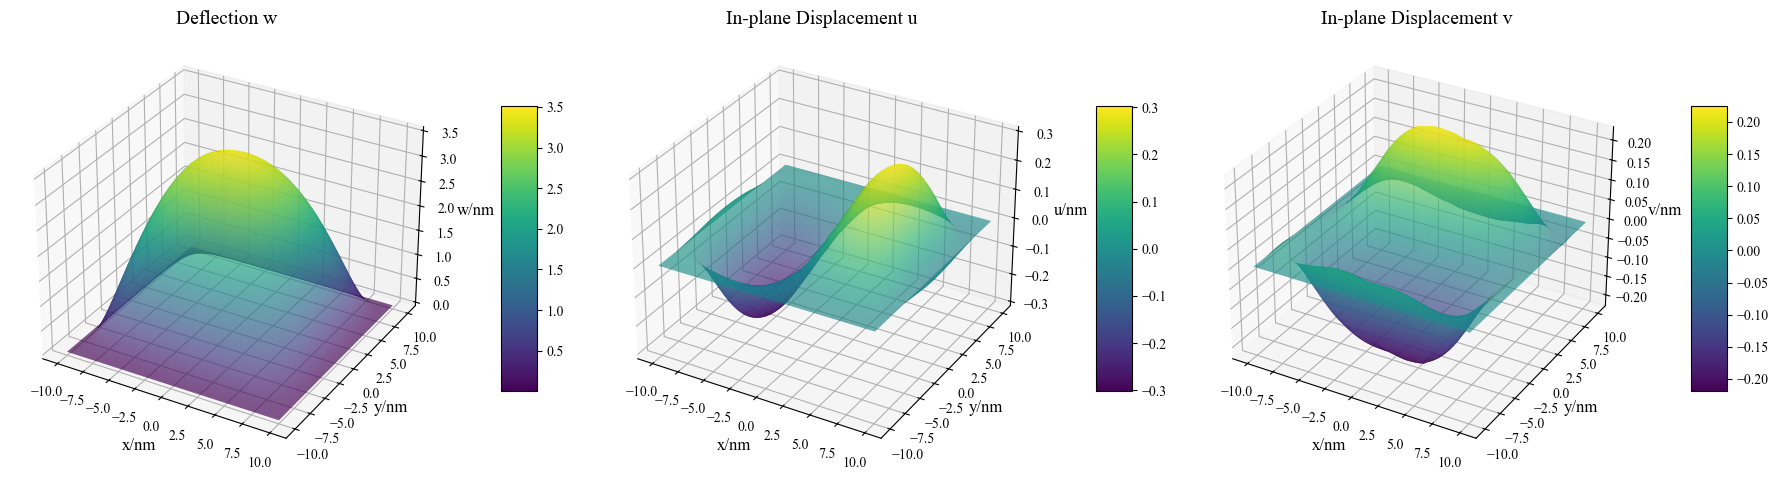

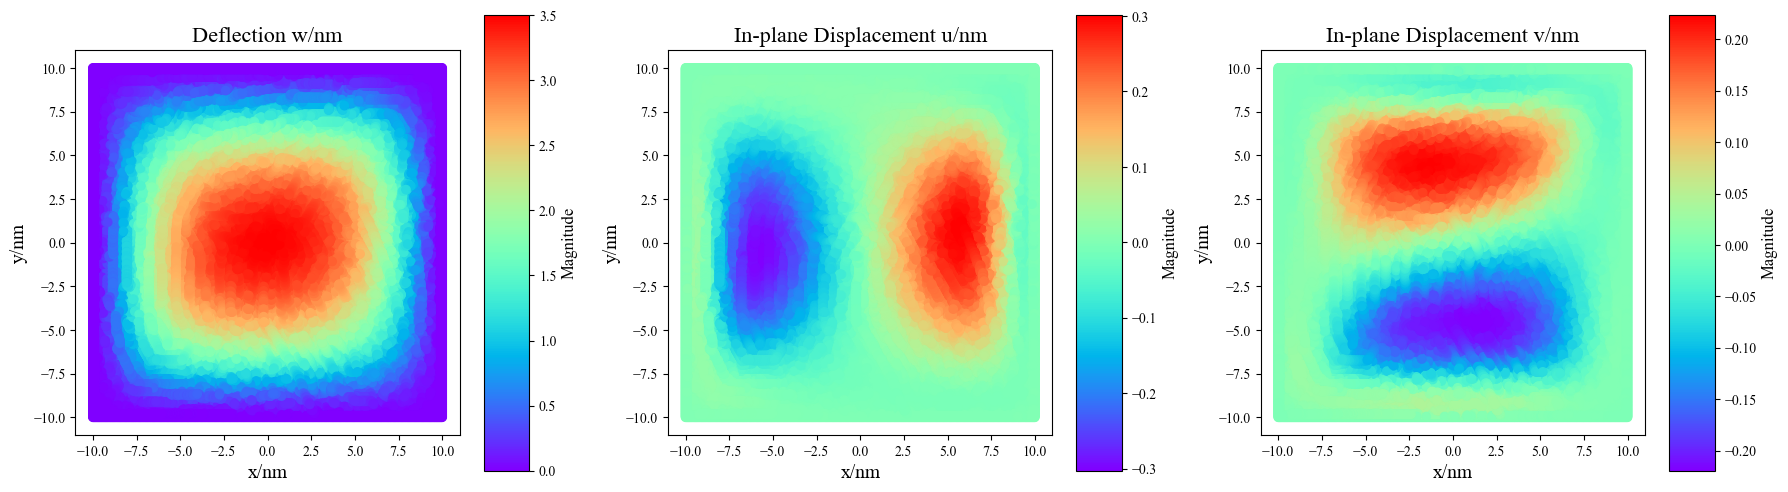

In [40]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Surface
fig1 = plt.figure(figsize=(18, 6))

subplotw = fig1.add_subplot(131, projection='3d')
surfw = subplotw.plot_trisurf(x, y, w, cmap='viridis', linewidth=0.2, antialiased=True)
subplotw.set_title(r'Deflection w', fontsize=14)
subplotw.set_xlabel(r'x/nm', fontsize=12)
subplotw.set_ylabel(r'y/nm', fontsize=12)
subplotw.set_zlabel(r'w/nm', fontsize=12)
fig1.colorbar(surfw, ax=subplotw, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

subplotu = fig1.add_subplot(132, projection='3d')
surfu = subplotu.plot_trisurf(x, y, u, cmap='viridis', linewidth=0.2, antialiased=True)
subplotu.set_title(r'In-plane Displacement u', fontsize=14)
subplotu.set_xlabel(r'x/nm', fontsize=12)
subplotu.set_ylabel(r'y/nm', fontsize=12)
subplotu.set_zlabel(r'u/nm', fontsize=12)
fig1.colorbar(surfu, ax=subplotu, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

subplotv = fig1.add_subplot(133, projection='3d')
surfv = subplotv.plot_trisurf(x, y, v, cmap='viridis', linewidth=0.2, antialiased=True)
subplotv.set_title(r'In-plane Displacement v', fontsize=14)
subplotv.set_xlabel(r'x/nm', fontsize=12)
subplotv.set_ylabel(r'y/nm', fontsize=12)
subplotv.set_zlabel(r'v/nm', fontsize=12)
fig1.colorbar(surfv, ax=subplotv, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

plt.tight_layout()
plt.show()

# Scatter
fig2 = plt.figure(figsize=(18, 6))

subplotww = fig2.add_subplot(131)
scw = subplotww.scatter(x, y, c=w, cmap='rainbow')
subplotww.set_title(r'Deflection w/nm', fontsize=16)
subplotww.set_xlabel(r'x/nm', fontsize=14)
subplotww.set_ylabel(r'y/nm', fontsize=14)
subplotww.set_aspect('equal')
cbw = plt.colorbar(scw, ax=subplotww, shrink=0.8, aspect=10)
cbw.set_label('Magnitude', fontsize=12)

subplotuu = fig2.add_subplot(132)
scu = subplotuu.scatter(x, y, c=u, cmap='rainbow')
subplotuu.set_title(r'In-plane Displacement u/nm', fontsize=16)
subplotuu.set_xlabel(r'x/nm', fontsize=14)
subplotuu.set_ylabel(r'y/nm', fontsize=14)
subplotuu.set_aspect('equal')
cbu = plt.colorbar(scu, ax=subplotuu, shrink=0.8, aspect=10)
cbu.set_label('Magnitude', fontsize=12)

subplotvv = fig2.add_subplot(133)
scv = subplotvv.scatter(x, y, c=v, cmap='rainbow')
subplotvv.set_title(r'In-plane Displacement v/nm', fontsize=16)
subplotvv.set_xlabel(r'x/nm', fontsize=14)
subplotvv.set_ylabel(r'y/nm', fontsize=14)
subplotvv.set_aspect('equal')
cbv = plt.colorbar(scv, ax=subplotvv, shrink=0.8, aspect=10)
cbv.set_label('Magnitude', fontsize=12)

plt.tight_layout()
plt.show()
